# Model Testing Notebook: Loading Datasets & Pre-Trained Model

**Objective:**  
Load the pre-generated datasets and the pre-trained NumerosityCNNTransformer model, evaluate its performance on the test set, and visualize the results.

- Set reproducibility seed and import libraries.
- Load the saved datasets.
- Load the pre-trained model.
- Evaluate the model on the test set (loss, accuracy, confusion matrix, and classification report).
- Visualize sample predictions.

**Note:**  
Make sure that the files **`train_dataset.pt`,** **`val_dataset.pt`**, **`test_dataset.pt`** and **`final_numerosity_model.pt`** are in your working directory.



# Environment Setup and Seed Setting

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Load Saved Datasets

In [4]:
from torch.utils.data import Dataset

class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

from torch.utils.data.dataset import Subset
import torch.serialization

torch.serialization.add_safe_globals([Subset])

# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 3500
Validation Dataset Size: 750
Test Dataset Size: 750


# Define the Model Architecture

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class NumerosityCNNTransformer(nn.Module):
    def __init__(self, image_size=128, patch_size=4, embed_dim=128, num_heads=4, num_layers=2, num_classes=3):
        super(NumerosityCNNTransformer, self).__init__()

        # CNN Backbone with Residual Blocks
        self.cnn_layers = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )

        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (16 // patch_size) ** 2

        # Patch embedding using convolution
        self.patch_embedding = nn.Conv2d(128, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regularization & Classification Head
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        out = self.cnn_layers(x)

        # Convert CNN features into patches
        patches = self.patch_embedding(out)
        patches = patches.flatten(2).transpose(1, 2)

        # Add positional encoding
        patches += self.pos_embedding

        # Transformer processing
        transformer_out = self.transformer_encoder(patches)

        # Pooled output & classification
        pooled_out = transformer_out.mean(dim=1)
        pooled_out = self.layer_norm(pooled_out)
        pooled_out = self.dropout(pooled_out)

        return self.fc(pooled_out)

# Load the Pre-Trained Model

### Load the pre-trained model from the saved checkpoint "final_numerosity_model.pt".

In [15]:
model = NumerosityCNNTransformer().to(device)
model.load_state_dict(torch.load("final_numerosity_model.pt", map_location=device))
model.eval()
print("Pre-trained model loaded successfully.")

Pre-trained model loaded successfully.


# Evaluate the Model on the Test Set

### Compute test loss, test accuracy and generate confusion matrix and classification report.

In [16]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    return avg_loss, accuracy, all_labels, all_preds

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.2842, Test Accuracy: 93.33%


# Confusion Matrix

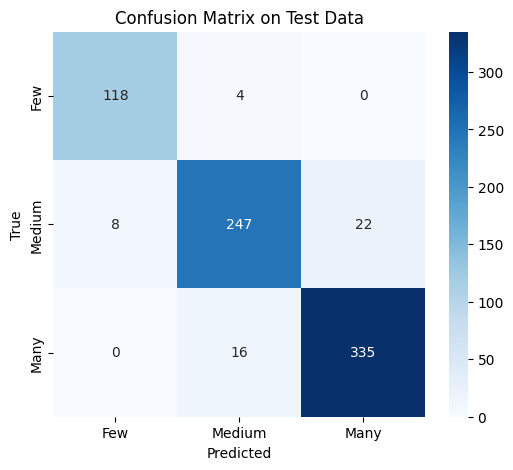

Classification Report:
              precision    recall  f1-score   support

         Few       0.94      0.97      0.95       122
      Medium       0.93      0.89      0.91       277
        Many       0.94      0.95      0.95       351

    accuracy                           0.93       750
   macro avg       0.93      0.94      0.94       750
weighted avg       0.93      0.93      0.93       750



In [17]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Few", "Medium", "Many"], yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))

# Visualize Test Images with Predictions

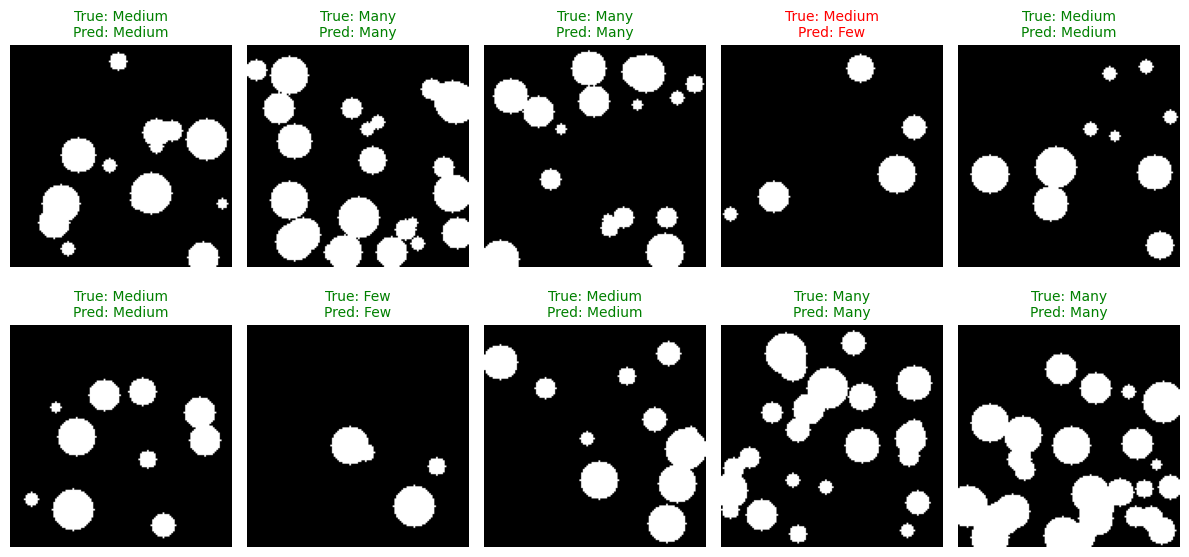

In [18]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Map numeric labels to class names
label_names = {0: "Few", 1: "Medium", 2: "Many"}

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 sample test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    true_label = label_names[labels[i].item()]
    pred_label = label_names[predicted[i].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Save Experiment Results

In [ ]:
torch.save(model.state_dict(), "final_numerosity_model.pt")
print("Final model saved as 'final_numerosity_model_loaded.pt'.")

results_dict = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
}
pd.DataFrame(results_dict).to_csv("experiment_results_run.csv", index=False)
print("Experiment results saved as 'experiment_results_run.csv'.")

Final model saved as 'final_numerosity_model.pt'.
Experiment results saved as 'experiment_results_run.csv'.
